<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import numpy as np
import random

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [5]:
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 30
batch_size = 16
noise_factor = 1

In [ ]:
def add_noise(img):
    '''Add gaussian noise to images'''
    #VARIABILITY = 50
    #deviation = VARIABILITY*random.random()
    noise_factor=0.5
    noise = noise_factor * np.random.normal(0, 255., img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
def tuple_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [6]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = noise_factor * np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [7]:
#Clean data
train_datagen = ImageDataGenerator(rescale=1. / 255)

val_datagen = ImageDataGenerator(rescale=1. / 255,) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='input') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='input')

#Adding noise
train_noisy = noisy_generator(train_generator)
val_noisy = noisy_generator(validation_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

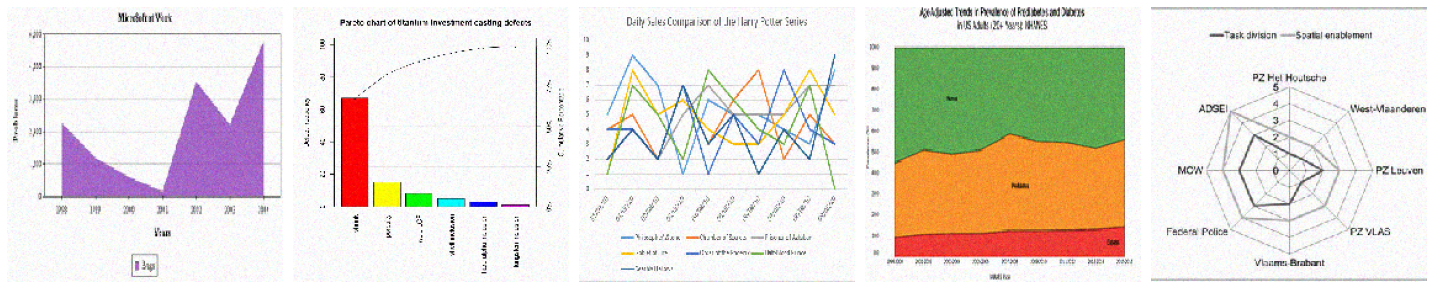

In [9]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:5])

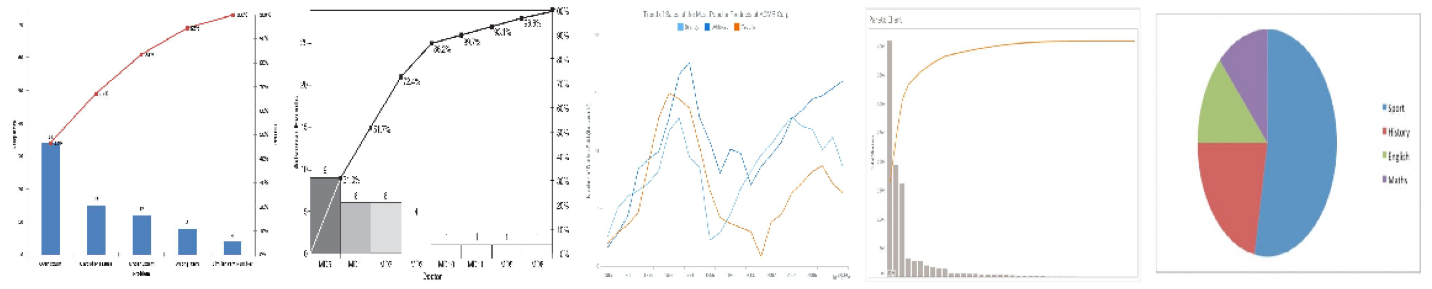

In [10]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [11]:
input_img = Input(shape=(img_width, img_height, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
autoencoder.fit(train_noisy, 
                epochs=epochs,
                steps_per_epoch = nb_train_samples // batch_size,
                verbose=1,
                validation_steps = nb_validation_samples // batch_size,
                validation_data= val_noisy)

Epoch 1/30
35/35 [==============================] - 553s 16s/step - loss: 2.9772 - accuracy: 0.4213 - val_loss: 2.9357 - val_accuracy: 0.8334
Epoch 2/30
35/35 [==============================] - 10s 293ms/step - loss: 2.9776 - accuracy: 0.4482 - val_loss: 2.9292 - val_accuracy: 0.4966
Epoch 3/30
35/35 [==============================] - 10s 293ms/step - loss: 2.9705 - accuracy: 0.4647 - val_loss: 2.9273 - val_accuracy: 0.2949
Epoch 4/30
35/35 [==============================] - 10s 286ms/step - loss: 2.9633 - accuracy: 0.4111 - val_loss: 2.9464 - val_accuracy: 0.7591
Epoch 5/30
35/35 [==============================] - 10s 289ms/step - loss: 2.9739 - accuracy: 0.4974 - val_loss: 2.9286 - val_accuracy: 0.2230
Epoch 6/30
35/35 [==============================] - 10s 292ms/step - loss: 2.9539 - accuracy: 0.4529 - val_loss: 2.9228 - val_accuracy: 0.8443
Epoch 7/30
35/35 [==============================] - 10s 296ms/step - loss: 2.9707 - accuracy: 0.4814 - val_loss: 2.9309 - val_accuracy: 0.2784


In [23]:
X, y = next(val_noisy)

In [24]:
decode_img = autoencoder.predict(X)


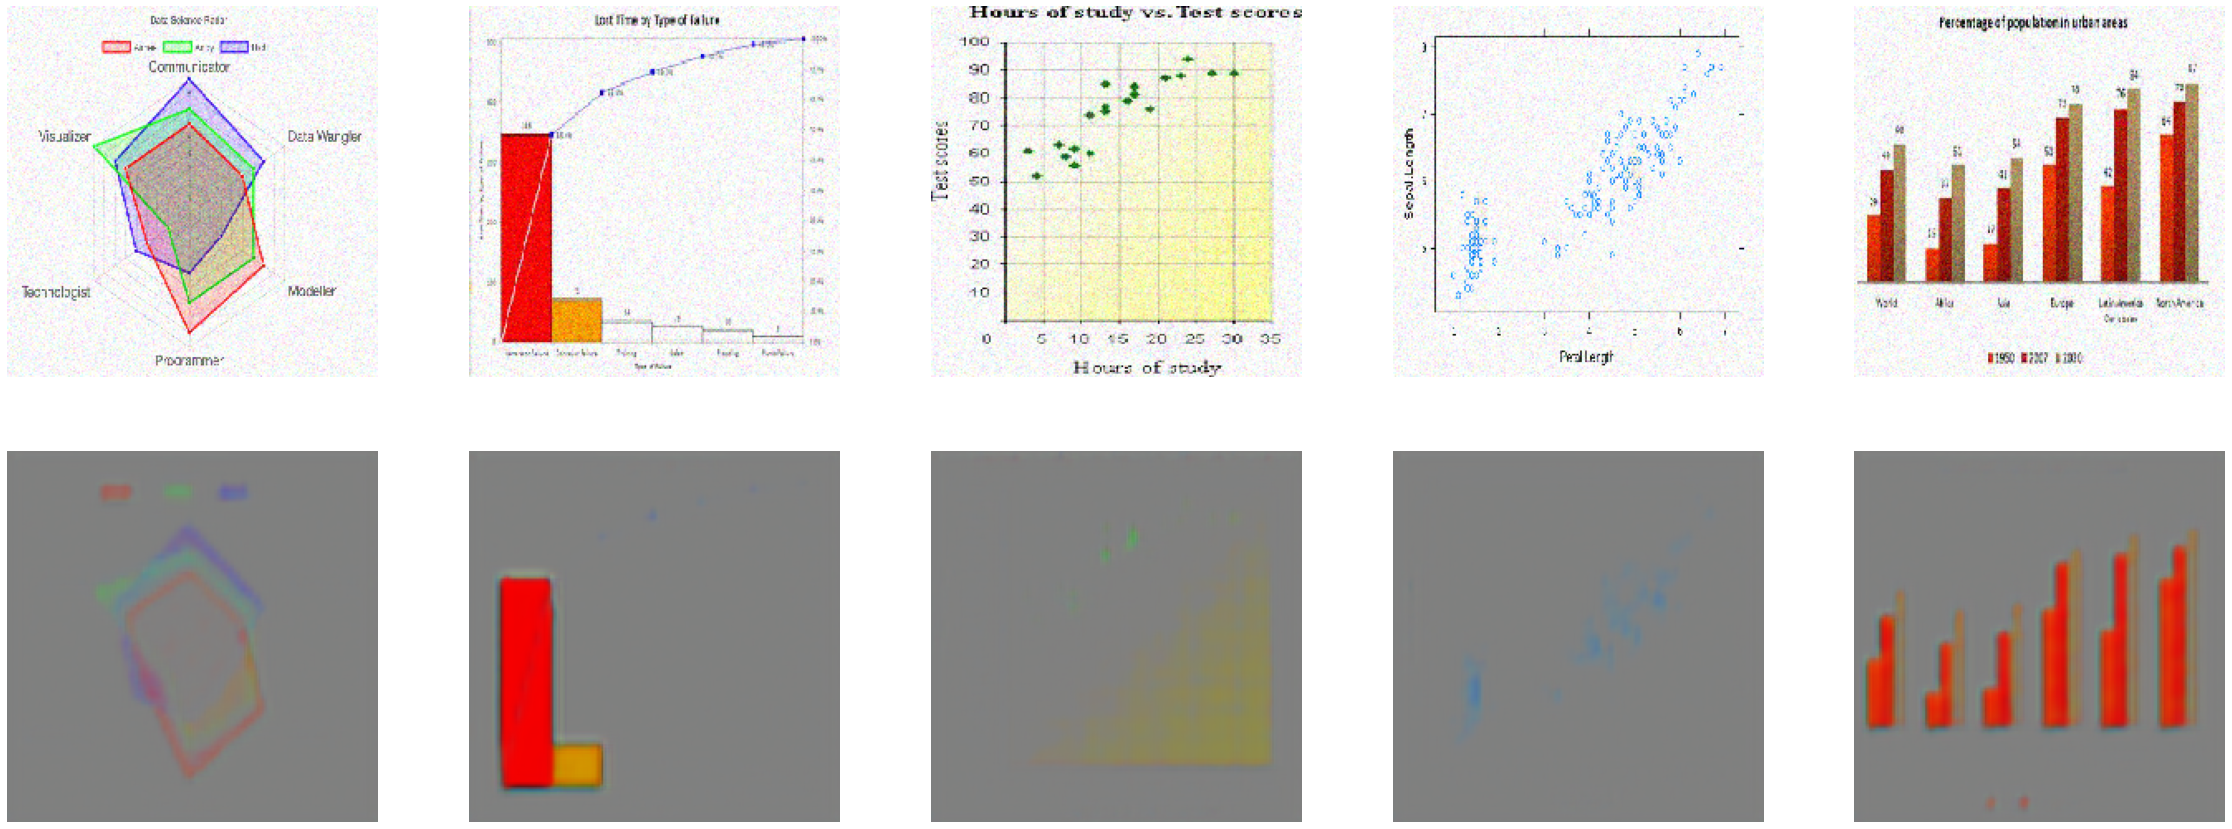

In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf


n = 5

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i])
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decode_img[i].reshape((224,224,3)) )
    ax.axis('off')

plt.show()

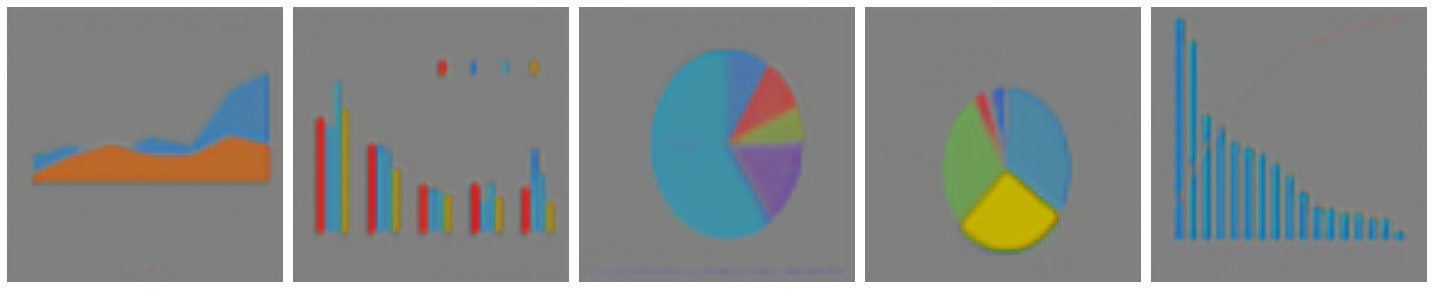

In [19]:
plotImages(decode_img[:5])